# Introduction-

In this competition, we have to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

For each id in the test set, we must predict a probability that center 32x32px region of a patch contains at least one pixel of tumor tissue.

Link to competition- https://www.kaggle.com/c/histopathologic-cancer-detection/overview

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from tqdm import trange
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D,Dropout,BatchNormalization,Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [3]:
labels=pd.read_csv('train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<H1> EDA

Given the training set contains >200k images, the RAM required is quite a lot and given my system constraints, I chose to use a subset of 14000 images with 7000 images for each class to train the model.

In [4]:
subset_label_0=[]
subset_label_1=[]
for i in range(len(labels)):
  if labels['label'][i]==0 and len(subset_label_0)!=7000:
    subset_label_0.append(labels['id'][i])
  elif labels['label'][i]==1 and len(subset_label_1)!=7000:
    subset_label_1.append(labels['id'][i])

In [5]:
dataset=[]
for image,j in zip(subset_label_0,trange(7000)):
  img=Image.open('train/{0}.tif'.format(image))
  img_array=np.array(img)/255
  dataset.append(img_array)

for image,j in zip(subset_label_1,trange(7000)):
  img=Image.open('train/{0}.tif'.format(image))
  img_array=np.array(img)/255
  dataset.append(img_array)

100%|█████████▉| 6999/7000 [00:16<00:00, 435.39it/s]


In [6]:
dataset=np.array(dataset,dtype=np.float64)

As we can see, we now have a tensor which consists of 14000 images which are 96x96 with the 3 colour channels.

In [7]:
dataset.shape

(14000, 96, 96, 3)

I now synthetically create my output training label since i loaded my images in order of their output.

In [8]:
y=np.append(np.zeros(7000),np.ones(7000))
y

array([0., 0., 0., ..., 1., 1., 1.])

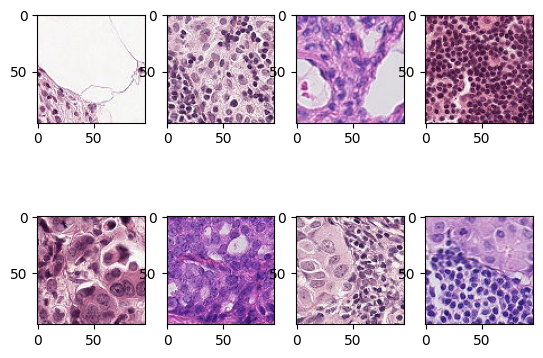

In [9]:
fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(dataset[0])
axs[0,1].imshow(dataset[1])
axs[0,2].imshow(dataset[2])
axs[0,3].imshow(dataset[3])

axs[1,0].imshow(dataset[-1])
axs[1,1].imshow(dataset[-2])
axs[1,2].imshow(dataset[-3])
axs[1,3].imshow(dataset[-4])

As shown above, I plot a few images from both classes. To the untrained eye, it would be very difficult to tell if the above images contain the cancerous cell or not. Which is why we're going to train a Convolutional Neural Network to identify it for us

<H1> Model architecture

I first split my dataset into training and validation set with a split of 85:15 -> 5950 images in training set and 1150 images in validation set.

In [10]:
X_train,X_val,y_train,y_val=train_test_split(dataset,y,test_size=0.15,random_state=32,shuffle=True)

Now I will create a CNN model from scratch and to ensure the model doesn't overfit the dataset since I'm only working with a subset, I use the below techniques for regularisation-

1) Dropout <br>
2) L2 regularization <br>
3) BatchNormalization <br>

In [11]:
model=Sequential()

model.add(Conv2D(32,3,strides=(2,2),activation='relu',input_shape=(96,96,3),use_bias=True,kernel_regularizer='l2',kernel_initializer='random_normal'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(64,3,strides=(2,2),activation='relu',use_bias=True,kernel_initializer='random_normal',kernel_regularizer='l2'))
model.add(Dropout(0.4))
model.add(Conv2D(128,3,activation='relu',use_bias=True,kernel_initializer='random_normal',kernel_regularizer='l2'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(256,3,activation='relu',use_bias=True,kernel_initializer='random_normal',kernel_regularizer='l2'))
model.add(Dropout(0.4))

model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_initializer='random_normal',kernel_regularizer='l2'))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


For optimization, I choose to use Adam optimizer as I personally feel that it's great at optimizing even if it is a bit slower than some other methods. And I also apply a step down learning rate which reduces the effective learning rate by half depending on progress of validation loss. I start with a learning rate of 0.001 and set minimum as 0.0001.

Aside from optimization, I use the binary cross entropy loss method as it's a binary problem and only track accuracy.

In [12]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

I also apply Early Stopping to ensure the model doesn't overfit. So if the validation loss doesnt improve in 15 iterations, the training stops and the model retains the weights which result in lowest validation loss.

In [13]:
callback=EarlyStopping(monitor='val_loss',patience=15,restore_best_weights=True)

Now let's see a summary of the model and number of parameters

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 47, 47, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 23, 23, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 4, 4, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 652,737 (2.49 MB)

 Trainable params: 651,905 (2.49 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr,callback],
    verbose=1
)

<H1> Results and Analysis

I ran several different variations of the models with more and less number of layers. I saw that with adding more layers, the model started to overfit the data.

I also saw that with lower layers, the model accuracy improved till a certain extent and then stagnated resulting in early stopping of the training process.

I also tried different values of dropout and swapped between MaxPooling and AveragePooling and saw AveragePooling gave a better result.

Now let's check how my final model performed-

In [17]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(train_loss) + 1)

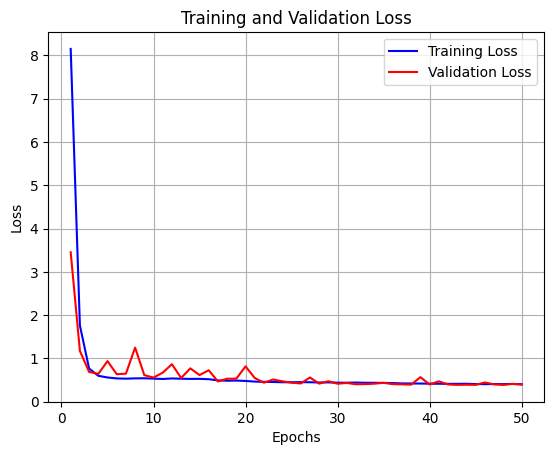

In [18]:
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

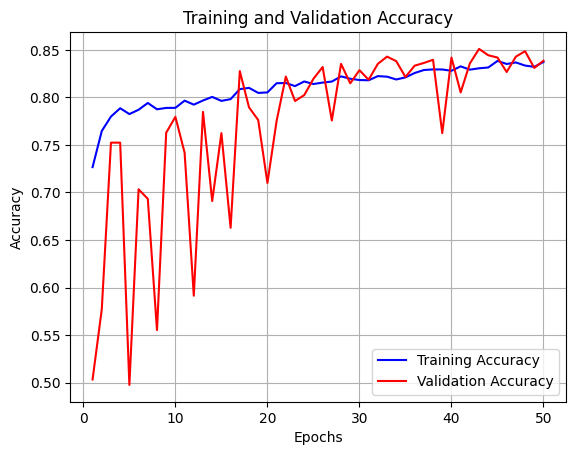

In [19]:
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

As we can see from the above two charts, the validation loss managed to converge with the training loss which is a good sign that our model didn't overfit.

In the second chart, we can see the validation accuracy improving as well until it converged with the training accuracy further strenthening the argument that the model did not overfit on the data.

In [20]:
model.save('Cancer_model.keras')

Now I saved the model for future use or in case the notebook crashes and used it on the test set for submission on kaggle

In [67]:
test_data=[]
for name in os.listdir('./test'):
  test_data.append(name)

In [58]:
test_dataset=[]
for image in os.listdir('./test'):
  img=Image.open('test/{0}'.format(image))
  img_array=np.array(img)/255
  test_dataset.append(img_array)

In [59]:
test_dataset=np.array(test_dataset,dtype=np.float64)

In [4]:
model=keras.models.load_model('Cancer_model.keras')

In [60]:
y_pred=model.predict(test_dataset)

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
df={
    'id':test_data,
    'label':y_pred
}

df=pd.DataFrame(y_pred,columns=['label'])
df.to_csv('submission.csv',index=False)

<H1> Conclusion

In this assignment, I had to create and train a CNN model on the Cancer Detection database for a kaggle competition and submit it.

I used a subset of 14000 images for training as I had limited computational power and still I feel my model achieved good results.

As seen above, my model achieved a ~83% of accuracy on both training and validation set ensuring it didnt overfit the data.